# Load data, find match Patient in RNA-Seq and Proteomics data

In [1]:
import os
import pandas as pd

# Ensure the output directory exists
output_dir = "dataset/processed/1. Data_preparation-matching_ID/Proteome/"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# Load cohort data (RNA-Seq)
gdc_df = pd.read_csv("dataset/CPTAC/RNA-Seq/gdc_sample_sheet.2025-02-14.tsv", sep="\t")

# Load PDC biospecimen data (Proteomics)
pdc_df = pd.read_csv("dataset/CPTAC/Proteomics/Primary_tumor/PDC_biospecimen_manifest_02152025_021616.tsv", sep="\t")

# Convert to string to avoid type mismatch
gdc_samples = set(gdc_df["Case ID"].astype(str))
pdc_samples = set(pdc_df["Case Submitter ID"].astype(str))

# Find matched samples
matched_samples = pdc_samples.intersection(gdc_samples)

# Find samples that exist only in Proteomics but not in RNA-Seq
proteomics_only = pdc_samples - gdc_samples

# Find samples that exist only in RNA-Seq but not in Proteomics
rna_seq_only = gdc_samples - pdc_samples

# Extract matched samples with their corresponding Aliquot Submitter ID
matched_df = pdc_df[pdc_df["Case Submitter ID"].astype(str).isin(matched_samples)][
    ["Case Submitter ID", "Aliquot Submitter ID"]
].reset_index(drop=True)  # Reset index

# Save CSV files
matched_df.to_csv(f"{output_dir}/matched_samples_with_aliquot.csv", index=False)
pd.DataFrame({"Proteomics_only": list(proteomics_only)}).to_csv(f"{output_dir}/proteomics_only.csv", index=False)
pd.DataFrame({"RNA_Seq_only": list(rna_seq_only)}).to_csv(f"{output_dir}/rna_seq_only.csv", index=False)

# Display results
print(f"✅ Matched sample count: {len(matched_samples)}")
print(f"✅ Matched samples with Aliquot ID found: {len(matched_df)}")
print(f"❌ Samples in Proteomics but not in RNA-Seq: {len(proteomics_only)} → {proteomics_only}")
print(f"❌ Samples in RNA-Seq but not in Proteomics: {len(rna_seq_only)} → {rna_seq_only}")
print(f"📂 Matched samples saved to '{output_dir}/matched_samples_with_aliquot.csv'")
print(f"📂 Proteomics-only samples saved to '{output_dir}/proteomics_only.csv'")
print(f"📂 RNA-Seq-only samples saved to '{output_dir}/rna_seq_only.csv'")


✅ Matched sample count: 121
✅ Matched samples with Aliquot ID found: 121
❌ Samples in Proteomics but not in RNA-Seq: 4 → {'11BR076', '11BR057', '03BR011', '11BR078'}
❌ Samples in RNA-Seq but not in Proteomics: 12 → {'100004012', '05BR051', '100003304', '03BR012', '1488', '11BR069', '05BR052', '05BR058', '05BR031', '05BR055', '100004028', '100002921'}
📂 Matched samples saved to 'dataset/processed/1. Data_preparation-matching_ID//matched_samples_with_aliquot.csv'
📂 Proteomics-only samples saved to 'dataset/processed/1. Data_preparation-matching_ID//proteomics_only.csv'
📂 RNA-Seq-only samples saved to 'dataset/processed/1. Data_preparation-matching_ID//rna_seq_only.csv'


## load protein expression data and valid the data 

In [2]:
import pandas as pd

# Load proteomics data
Proteomic_df = pd.read_csv("dataset/CPTAC/Proteomics/Primary_tumor/protein assembly/CPTAC2_Breast_Prospective_Collection_BI_Proteome.tmt10.tsv", sep="\t")

# Extract column names
proteomic_cols = Proteomic_df.columns

# Get columns matching Aliquot IDs
aliquot_ids = matched_df["Aliquot Submitter ID"].tolist()

# Separate Log Ratio and Unshared Log Ratio
log_ratio_cols = [col for col in proteomic_cols if any(aliquot in col for aliquot in aliquot_ids) and "Log Ratio" in col and "Unshared" not in col]
unshared_log_ratio_cols = [col for col in proteomic_cols if any(aliquot in col for aliquot in aliquot_ids) and "Unshared Log Ratio" in col]

# Rename columns to keep only the aliquot ID
log_ratio_cleaned = {col: col.split()[0] for col in log_ratio_cols}
unshared_log_ratio_cleaned = {col: col.split()[0] for col in unshared_log_ratio_cols}

# Extract and rename data
Proteomic_log_df = Proteomic_df[["Gene"] + log_ratio_cols].rename(columns=log_ratio_cleaned)
Proteomic_unshared_df = Proteomic_df[["Gene"] + unshared_log_ratio_cols].rename(columns=unshared_log_ratio_cleaned)

# Save to separate files
Proteomic_log_df.to_csv("dataset/processed/1. Data_preparation-matching_ID/Proteome/Proteomic_matched_log.csv", index=False)
Proteomic_unshared_df.to_csv("dataset/processed/1. Data_preparation-matching_ID/Proteome/Proteomic_matched_unshared.csv", index=False)

# Display results
print(f"✅ Found {len(log_ratio_cols)} matched 'Log Ratio' columns in Proteomic_df.")
print(f"✅ Found {len(unshared_log_ratio_cols)} matched 'Unshared Log Ratio' columns in Proteomic_df.")
print(f"📂 Filtered proteomics data saved to:")
print(f"   - 'dataset/processed/1. Data_preparation-matching_ID/Proteome/Proteomic_matched_log.csv'")
print(f"   - 'dataset/processed/1. Data_preparation-matching_ID/Proteome/Proteomic_matched_unshared.csv'")


✅ Found 129 matched 'Log Ratio' columns in Proteomic_df.
✅ Found 129 matched 'Unshared Log Ratio' columns in Proteomic_df.
📂 Filtered proteomics data saved to:
   - 'dataset/processed/1. Data_preparation-matching_ID/Proteomic_matched_log.csv'
   - 'dataset/processed/1. Data_preparation-matching_ID/Proteomic_matched_unshared.csv'


## Found the dataset is more than matched_patient data. Dive into and check

In [3]:

# 🔹 1️⃣ Retrieve `Aliquot Submitter ID` from matched_df
aliquot_ids = set(matched_df["Aliquot Submitter ID"])

# 🔹 2️⃣ Count occurrences of each ID in Proteomic_unshared_df
id_count = {aliquot_id: sum(Proteomic_unshared_df.columns.str.contains(aliquot_id)) for aliquot_id in aliquot_ids}

# 🔹 3️⃣ Filter IDs that match **two or more** columns
multiple_matches = {k: v for k, v in id_count.items() if v > 1}

# 🔹 4️⃣ Convert to DataFrame for easier viewing
multiple_matches_df = pd.DataFrame(list(multiple_matches.items()), columns=["Aliquot Submitter ID", "Matched Columns Count"])

# 🔹 5️⃣ Save as CSV
multiple_matches_df.to_csv("dataset/processed/1. Data_preparation-matching_ID/Proteome/aliquot_ids_with_multiple_matches.csv", index=False)

# 🔹 6️⃣ Output results
print(f"🔍 Found {len(multiple_matches_df)} Aliquot Submitter IDs that match 2 or more columns.")
print(multiple_matches_df)


🔍 Found 7 Aliquot Submitter IDs that match 2 or more columns.
                Aliquot Submitter ID  Matched Columns Count
0  68ef4aa9-00b0-4528-8828-4d3e43_D2                      2
1  3fdf0dbe-e05c-465f-8bed-4a92dd_D2                      2
2  fb526979-ee2d-4edf-b41d-01074f_D2                      2
3  97cc4d46-cf80-41f1-b99c-bc4829_D2                      2
4  2386c36d-8d5d-4fd4-bbfa-39cc8d_D2                      2
5  45b99ac4-0859-4a3d-8b1e-ce5590_D2                      3
6  bc9fe67f-c4a2-43ba-87bd-438bda_D2                      2


In [4]:
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 1️⃣ Remove AnalyticalSample and store it as color labels
analytical_samples = Proteomic_unshared_df.iloc[-1, :].copy()  # Extract AnalyticalSample
Proteomic_unshared_df = Proteomic_unshared_df.iloc[:-1, :]  # Remove AnalyticalSample row

# 🔹 2️⃣ Fill NaN values with the Mean row
Proteomic_unshared_df = Proteomic_unshared_df.fillna(Proteomic_unshared_df.iloc[0])  # Fill using the first row

# 🔹 3️⃣ Remove Mean, Median, StdDev rows
Proteomic_unshared_df = Proteomic_unshared_df.drop(["Mean", "Median", "StdDev"], axis=0)

# 🔹 4️⃣ Transpose the data so that rows represent samples and columns represent genes
Proteomic_unshared_df = Proteomic_unshared_df.T  # Transpose for PCA format

# 🔹 5️⃣ Standardization (Z-score normalization)
scaler = StandardScaler()
proteomic_scaled = scaler.fit_transform(Proteomic_unshared_df)

# 🔹 6️⃣ PCA Analysis
pca = PCA(n_components=2)
pca_result = pca.fit_transform(proteomic_scaled)

# 🔹 7️⃣ Create PCA DataFrame
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["AnalyticalSample"] = analytical_samples.reset_index(drop=True)  # Ensure index consistency

# 🔹 8️⃣ Plot PCA Graph
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="AnalyticalSample", palette="tab10", alpha=0.8)

# 🔹 Set title & axis labels
plt.title("PCA of Proteomic Unshared Data (Colored by AnalyticalSample)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)

# 🔹 Display plot
plt.show()

# 🔹 Load original TXT file
file_path = "dataset/CPTAC/Proteomics/Primary_tumor/protein assembly/CPTAC2_Breast_Prospective_Collection_BI_Proteome.sample.txt"
df = pd.read_csv(file_path, sep="\t")

# 🔹 Save as CSV format
csv_output_path = "dataset/processed/1. Data_preparation-matching_ID/Proteome/CPTAC2_Breast_Proteome_Sample.csv"
df.to_csv(csv_output_path, index=False)
print(f"✅ CSV file saved at: {csv_output_path}")

# 🔹 Select relevant columns
id_columns = ["126", "127N", "127C", "128N", "128C", "129N", "129C", "130N", "130C"]
df_selected = df[["AnalyticalSample"] + id_columns]

# 🔹 Reshape data to long format
df_melted = df_selected.melt(id_vars=["AnalyticalSample"], value_name="Aliquot_ID")
df_melted = df_melted.drop(columns=["variable"]).dropna()  # Remove NaN values

# 🔹 Remove Aliquot_IDs that contain "RetroIR"
df_melted = df_melted[~df_melted["Aliquot_ID"].str.startswith("RetroIR")]

# 🔹 Count occurrences of each Aliquot_ID across AnalyticalSamples
aliquot_counts = df_melted.groupby("Aliquot_ID")["AnalyticalSample"].nunique()

# 🔹 Identify Aliquot_IDs present in more than one AnalyticalSample
duplicated_aliquots = aliquot_counts[aliquot_counts > 1].index

# 🔹 Extract detailed information of these duplicated Aliquot_IDs
duplicated_aliquots_df = df_melted[df_melted["Aliquot_ID"].isin(duplicated_aliquots)]

# 🔹 Group by Aliquot_ID to list associated AnalyticalSamples
aliquot_to_samples = duplicated_aliquots_df.groupby("Aliquot_ID")["AnalyticalSample"].apply(list).reset_index()

# 🔹 Save results
aliquot_to_samples.to_csv("dataset/processed/1. Data_preparation-matching_ID/Proteome/Aliquot_IDs_with_multiple_AnalyticalSamples.csv", index=False, sep="\t")

# 🔹 Output results
print(f"🔍 Found {len(aliquot_to_samples)} Aliquot_IDs associated with multiple AnalyticalSamples (excluding RetroIR).")
print(aliquot_to_samples)


✅ CSV file saved at: dataset/processed/1. Data_preparation-matching_ID/CPTAC2_Breast_Proteome_Sample.csv
🔍 Found 7 Aliquot_IDs associated with multiple AnalyticalSamples (excluding RetroIR).
                          Aliquot_ID  \
0  2386c36d-8d5d-4fd4-bbfa-39cc8d_D2   
1  3fdf0dbe-e05c-465f-8bed-4a92dd_D2   
2  45b99ac4-0859-4a3d-8b1e-ce5590_D2   
3  68ef4aa9-00b0-4528-8828-4d3e43_D2   
4  97cc4d46-cf80-41f1-b99c-bc4829_D2   
5  bc9fe67f-c4a2-43ba-87bd-438bda_D2   
6  fb526979-ee2d-4edf-b41d-01074f_D2   

                                    AnalyticalSample  
0  [08CPTAC_BCprospective_Proteome_BC_20170104, 1...  
1  [02CPTAC_BCprospective_Proteome_BC_20160913, 0...  
2  [10CPTAC_BCprospective_Proteome_BC_20170224, 1...  
3  [17CPTAC_BCprospective_Proteome_BC_20170613, 0...  
4  [16CPTAC_BCprospective_Proteome_BC_20170609, 1...  
5  [17CPTAC_BCprospective_Proteome_BC_20170613, 0...  
6  [03CPTAC_BCprospective_Proteome_BC_20160916, 1...  


## Found the data have .1, .2, .3 version, check metadata

## Found the version is come from different batch. Check batch effect wuth PCA

In [7]:
import pandas as pd

# Load proteomics data
Proteomic_df = pd.read_csv("dataset/CPTAC/Proteomics/Primary_tumor/protein assembly/CPTAC2_Breast_Prospective_Collection_BI_Proteome.tmt10.tsv", sep="\t")

# Load sample information
sample_df = pd.read_csv("dataset/CPTAC/Proteomics/Primary_tumor/protein assembly/CPTAC2_Breast_Prospective_Collection_BI_Proteome.sample.txt", sep="\t")

# Extract column names
proteomic_cols = Proteomic_df.columns

# Get columns matching Aliquot IDs
aliquot_ids = matched_df["Aliquot Submitter ID"].tolist()

# Count occurrences of each Aliquot ID
aliquot_counts = {}
for _, row in sample_df.iterrows():
    for aliquot_id in row[2:]:  # Aliquot IDs start from the 3rd column
        if isinstance(aliquot_id, str) and aliquot_id in aliquot_ids:
            aliquot_counts[aliquot_id] = aliquot_counts.get(aliquot_id, 0) + 1


# Step 2: Extract only Aliquot IDs that appear **more than twice**
aliquots_to_modify = {aliq: count for aliq, count in aliquot_counts.items() if count >= 2}
print(f"🔍 Found {len(aliquots_to_modify)} Aliquot IDs appearing more than twice: {list(aliquots_to_modify.keys())}")

# Step 3: Iterate over the sample_df to modify Aliquot IDs
aliquot_suffix = {aliq: 1 for aliq in aliquots_to_modify}  # Track suffix count

# Loop through rows and columns to update Aliquot IDs
for row_idx in range(len(sample_df)):  # Iterate over rows (Analytical Samples)
    for col_idx in range(2, len(sample_df.columns)):  # Start from the 3rd column (Aliquot IDs)
        aliquot_id = sample_df.iloc[row_idx, col_idx]
        
        if isinstance(aliquot_id, str) and aliquot_id in aliquots_to_modify:
            # Update the Aliquot ID with the suffix (.1, .2, .3, ...)
            new_aliquot_id = f"{aliquot_id}.{aliquot_suffix[aliquot_id]}"
            sample_df.iloc[row_idx, col_idx] = new_aliquot_id

            # Increment the suffix for next occurrence
            aliquot_suffix[aliquot_id] += 1

sample_df.to_csv("dataset/processed/1. Data_preparation-matching_ID/Proteome/CPTAC2_Breast_Proteome_sample_modified.tsv", sep="\t", index=False)


🔍 Found 7 Aliquot IDs appearing more than twice: ['3fdf0dbe-e05c-465f-8bed-4a92dd_D2', 'fb526979-ee2d-4edf-b41d-01074f_D2', '68ef4aa9-00b0-4528-8828-4d3e43_D2', 'bc9fe67f-c4a2-43ba-87bd-438bda_D2', '2386c36d-8d5d-4fd4-bbfa-39cc8d_D2', '45b99ac4-0859-4a3d-8b1e-ce5590_D2', '97cc4d46-cf80-41f1-b99c-bc4829_D2']


### add batch "AnalyticalSample" from metadata to Proteomic_df and seperate them into log and unshared

In [11]:
# Load sample information
sample_df = pd.read_csv("dataset/processed/1. Data_preparation-matching_ID/Proteome/CPTAC2_Breast_Proteome_sample_modified.tsv", sep="\t")

# Extract column names
proteomic_cols = Proteomic_df.columns

# Get columns matching Aliquot IDs
aliquot_ids = matched_df["Aliquot Submitter ID"].tolist()

# Separate Log Ratio and Unshared Log Ratio
log_ratio_cols = [col for col in proteomic_cols if any(aliquot in col for aliquot in aliquot_ids) and "Log Ratio" in col and "Unshared" not in col]
unshared_log_ratio_cols = [col for col in proteomic_cols if any(aliquot in col for aliquot in aliquot_ids) and "Unshared Log Ratio" in col]

# Rename columns to keep only the aliquot ID
log_ratio_cleaned = {col: col.split()[0] for col in log_ratio_cols}
unshared_log_ratio_cleaned = {col: col.split()[0] for col in unshared_log_ratio_cols}

# Extract and rename data
Proteomic_log_df = Proteomic_df[["Gene"] + log_ratio_cols].rename(columns=log_ratio_cleaned)
Proteomic_unshared_df = Proteomic_df[["Gene"] + unshared_log_ratio_cols].rename(columns=unshared_log_ratio_cleaned)
Proteomic_log_df = Proteomic_log_df.set_index("Gene")
Proteomic_unshared_df = Proteomic_unshared_df.set_index("Gene")

# Create a mapping from Aliquot ID to Analytical Sample
aliquot_to_sample = {}
for _, row in sample_df.iterrows():
    analytical_sample = row["AnalyticalSample"]
    for aliquot_id in row[2:]:  # Aliquot IDs are in columns 3 onward
        if isinstance(aliquot_id, str):  # Keep only valid Aliquot IDs
            aliquot_to_sample[aliquot_id] = analytical_sample

# Add AnalyticalSample column based on Aliquot ID mapping
Proteomic_log_df = Proteomic_log_df.T  # Transpose to make Aliquot IDs as index
Proteomic_log_df["AnalyticalSample"] = Proteomic_log_df.index.map(aliquot_to_sample)
Proteomic_log_df = Proteomic_log_df.T  # Transpose back

Proteomic_unshared_df = Proteomic_unshared_df.T
Proteomic_unshared_df["AnalyticalSample"] = Proteomic_unshared_df.index.map(aliquot_to_sample)
Proteomic_unshared_df = Proteomic_unshared_df.T

# Save to separate files
Proteomic_log_df.to_csv("dataset/processed/1. Data_preparation-matching_ID/Proteome/Proteomic_matched_log_with_sample.csv", index=True)
Proteomic_unshared_df.to_csv("dataset/processed/1. Data_preparation-matching_ID/Proteome/Proteomic_matched_unshared_with_sample.csv", index=True)

# Display results
print(f"✅ Found {len(log_ratio_cols)} matched 'Log Ratio' columns in Proteomic_df.")
print(f"✅ Found {len(unshared_log_ratio_cols)} matched 'Unshared Log Ratio' columns in Proteomic_df.")
print(f"📂 Filtered proteomics data with AnalyticalSample saved to:")
print(f"   - 'dataset/processed/1. Data_preparation-matching_ID/Proteome/Proteomic_matched_log_with_sample.csv'")
print(f"   - 'dataset/processed/1. Data_preparation-matching_ID/Proteome/Proteomic_matched_unshared_with_sample.csv'")


✅ Found 129 matched 'Log Ratio' columns in Proteomic_df.
✅ Found 129 matched 'Unshared Log Ratio' columns in Proteomic_df.
📂 Filtered proteomics data with AnalyticalSample saved to:
   - 'dataset/processed/1. Data_preparation-matching_ID/Proteomic_matched_log_with_sample.csv'
   - 'dataset/processed/1. Data_preparation-matching_ID/Proteomic_matched_unshared_with_sample.csv'


## Do the PCA

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_78174/3279296055.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Proteomic_unshared_df = Proteomic_unshared_df.fillna(Proteomic_unshared_df.iloc[0])  # 用第一行填補


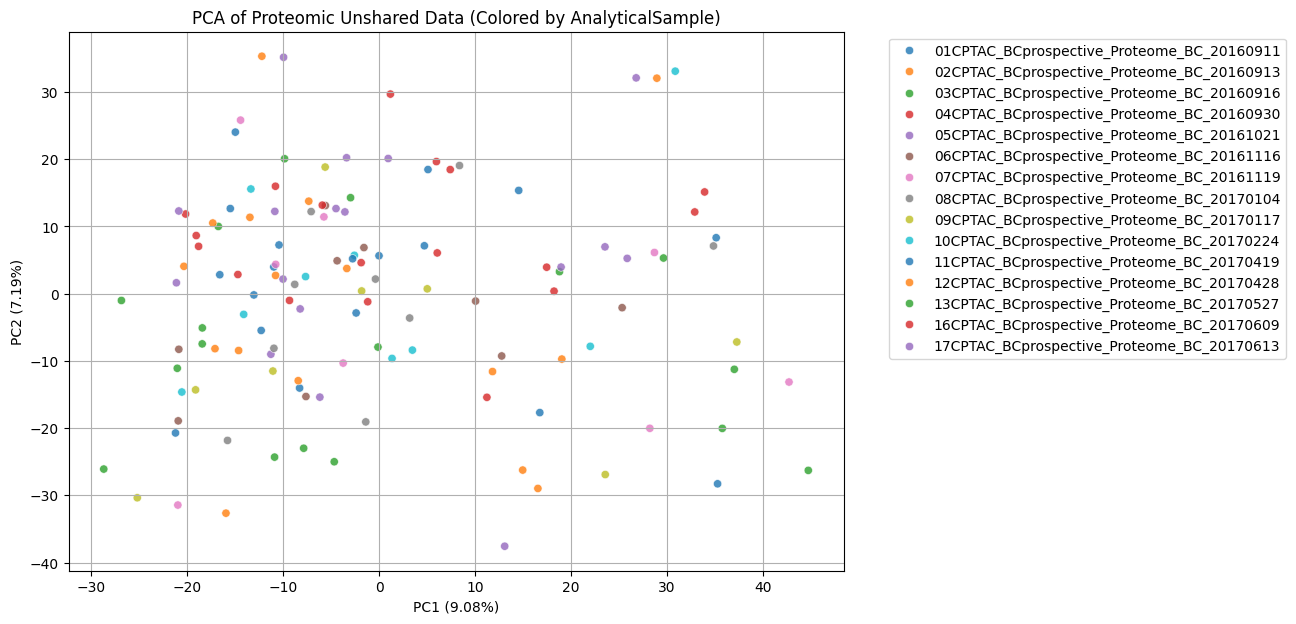

In [12]:
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 1️⃣ Remove AnalyticalSample and store it as color labels
analytical_samples = Proteomic_unshared_df.iloc[-1, :].copy()  # Extract AnalyticalSample
Proteomic_unshared_df = Proteomic_unshared_df.iloc[:-1, :]  # Remove AnalyticalSample row

# 🔹 2️⃣ Fill NaN values with the Mean row
Proteomic_unshared_df = Proteomic_unshared_df.fillna(Proteomic_unshared_df.iloc[0])  # Fill using the first row

# 🔹 3️⃣ Remove Mean, Median, StdDev rows
Proteomic_unshared_df = Proteomic_unshared_df.drop(["Mean", "Median", "StdDev"], axis=0)

# 🔹 4️⃣ Transpose the data so that rows represent samples and columns represent genes
Proteomic_unshared_df = Proteomic_unshared_df.T  # Transpose for PCA format

# 🔹 5️⃣ Standardization (Z-score normalization)
scaler = StandardScaler()
proteomic_scaled = scaler.fit_transform(Proteomic_unshared_df)

# 🔹 6️⃣ PCA Analysis
pca = PCA(n_components=2)
pca_result = pca.fit_transform(proteomic_scaled)

# 🔹 7️⃣ Create PCA DataFrame
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["AnalyticalSample"] = analytical_samples.reset_index(drop=True)  # Ensure index consistency

# 🔹 8️⃣ Plot PCA Graph
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="AnalyticalSample", palette="tab10", alpha=0.8)

# 🔹 Set title & axis labels
plt.title("PCA of Proteomic Unshared Data (Colored by AnalyticalSample)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)

# 🔹 Display plot
plt.show()

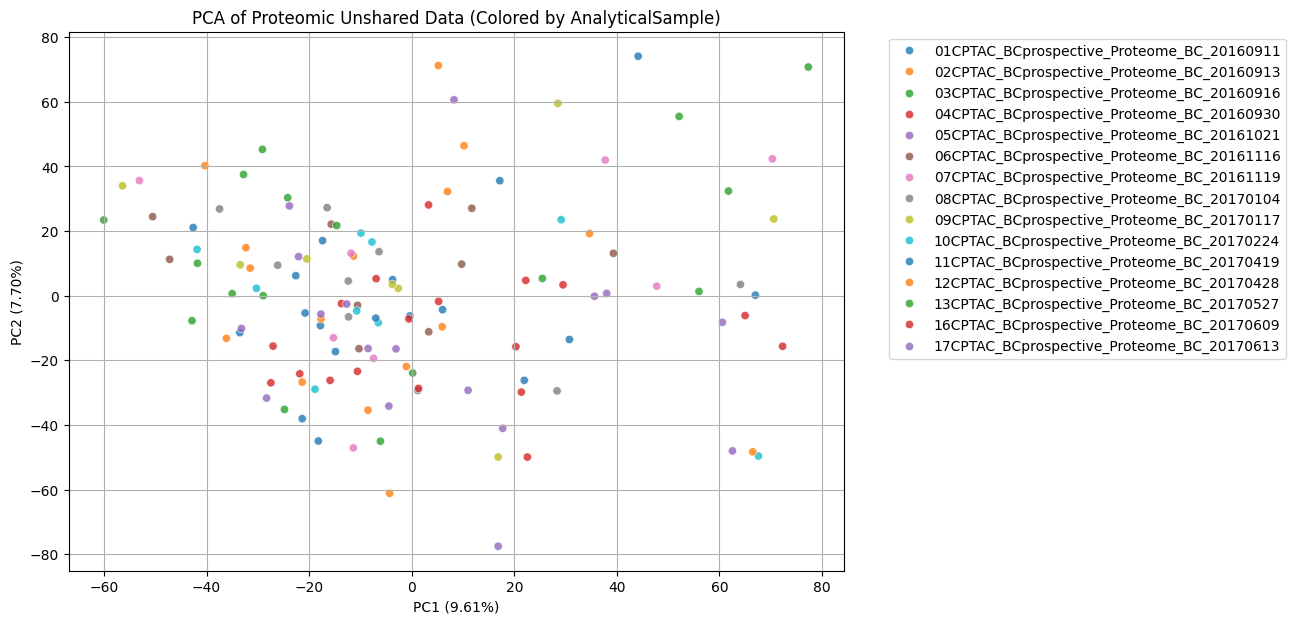

In [13]:
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 5️⃣ Standardization (Z-score normalization)
scaler = StandardScaler()
proteomic_scaled = scaler.fit_transform(Proteomic_unshared_df)

# 🔹 6️⃣ PCA Analysis
pca = PCA(n_components=2)
pca_result = pca.fit_transform(proteomic_scaled)

# 🔹 7️⃣ Create PCA DataFrame
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["AnalyticalSample"] = analytical_samples.reset_index(drop=True)  # Ensure index consistency

# 🔹 8️⃣ Plot PCA Graph
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="AnalyticalSample", palette="tab10", alpha=0.8)

# 🔹 Set title & axis labels
plt.title("PCA of Proteomic Unshared Data (Colored by AnalyticalSample)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)

# 🔹 Display plot
plt.show()

In [14]:
from scipy.stats import f_oneway

# Check whether PC1 is influenced by AnalyticalSample
groups = [pca_df[pca_df["AnalyticalSample"] == sample]["PC1"] for sample in pca_df["AnalyticalSample"].unique()]
stat, p_value = f_oneway(*groups)
print(f"PC1 vs AnalyticalSample ANOVA: p = {p_value:.4f}")


PC1 vs AnalyticalSample ANOVA: p = 0.7382


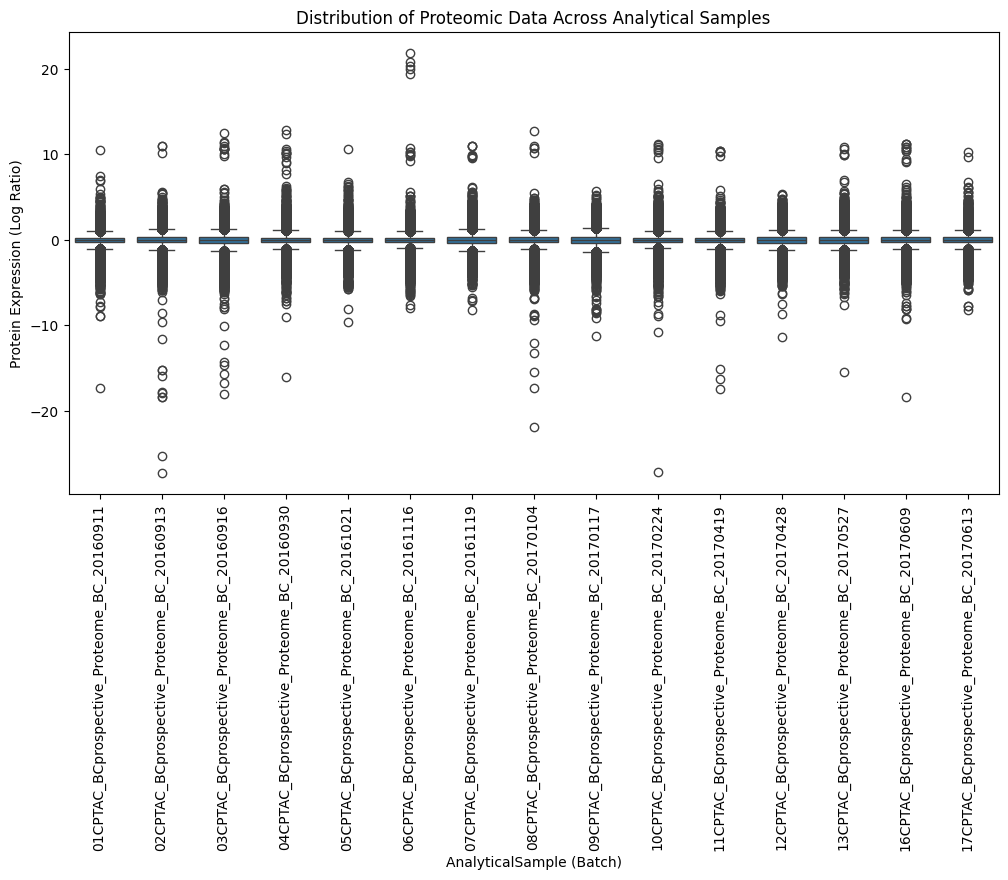

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape DataFrame to fit Seaborn plotting (long format)
melted_df = Proteomic_unshared_df.copy()
melted_df["AnalyticalSample"] = analytical_samples.values  # Re-add AnalyticalSample
melted_df = melted_df.melt(id_vars=["AnalyticalSample"], var_name="Gene", value_name="Expression")

# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x="AnalyticalSample", y="Expression", data=melted_df)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("Distribution of Proteomic Data Across Analytical Samples")
plt.xlabel("AnalyticalSample (Batch)")
plt.ylabel("Protein Expression (Log Ratio)")
plt.show()


## Obeserve there are no batch effect between different batch. 

# Use the average value as the protein expression if the case id have .1, .2, .3 

In [16]:
import pandas as pd

# 1️⃣ Load the datasets while avoiding DtypeWarning
Proteomic_log_df = pd.read_csv("dataset/processed/1. Data_preparation-matching_ID/Proteome/Proteomic_matched_log_with_sample.csv", low_memory=False)
Proteomic_unshared_df = pd.read_csv("dataset/processed/1. Data_preparation-matching_ID/Proteome/Proteomic_matched_unshared_with_sample.csv", low_memory=False)

# 2️⃣ Set the index to the "Gene" column
Proteomic_log_df = Proteomic_log_df.set_index("Gene")
Proteomic_unshared_df = Proteomic_unshared_df.set_index("Gene")

# 3️⃣ Fill NaN values with the first row (Mean values)
Proteomic_log_df = Proteomic_log_df.fillna(Proteomic_log_df.iloc[0])
Proteomic_unshared_df = Proteomic_unshared_df.fillna(Proteomic_unshared_df.iloc[0])

# 4️⃣ Ensure that index values do not contain extra spaces
Proteomic_log_df.index = Proteomic_log_df.index.str.strip()
Proteomic_unshared_df.index = Proteomic_unshared_df.index.str.strip()

# 5️⃣ Remove statistical summary rows: Mean, Median, StdDev, AnalyticalSample
Proteomic_log_df = Proteomic_log_df.drop(index=["Mean", "Median", "StdDev", "AnalyticalSample"], errors="ignore")
Proteomic_unshared_df = Proteomic_unshared_df.drop(index=["Mean", "Median", "StdDev", "AnalyticalSample"], errors="ignore")

# 6️⃣ Convert all data values to float type
Proteomic_log_df = Proteomic_log_df.apply(pd.to_numeric, errors="coerce")
Proteomic_unshared_df = Proteomic_unshared_df.apply(pd.to_numeric, errors="coerce")

# 7️⃣ Load duplicate sample IDs
duplic_id = pd.read_csv("dataset/processed/1. Data_preparation-matching_ID/Proteome/aliquot_ids_with_multiple_matches.csv")
duplic_ids = set(duplic_id['Aliquot Submitter ID'].tolist())  # Convert to set for faster lookup

# 8️⃣ Identify duplicate samples and compute their mean values
def merge_duplicate_samples(df, duplic_ids):
    df_no_duplicates = df.copy()
    mapping = {}

    for sample_id in df_no_duplicates.columns:
        for dup_id in duplic_ids:
            if sample_id.startswith(dup_id):  # Identify variants (e.g., 2386c36d-8d5d-4fd4-bbfa-39cc8d_D2.1)
                mapping[sample_id] = dup_id  # Map all variants to the original ID without `.1/.2/.3`

    # Rename columns so that variant names match the original ID
    df_no_duplicates = df_no_duplicates.rename(columns=mapping)

    # **Fix groupby(axis=1) to aggregate duplicated columns by mean**
    df_merged = df_no_duplicates.T.groupby(level=0).mean().T

    return df_merged

# 9️⃣ Merge duplicate samples
Proteomic_log_df = merge_duplicate_samples(Proteomic_log_df, duplic_ids)
Proteomic_unshared_df = merge_duplicate_samples(Proteomic_unshared_df, duplic_ids)

# 🔟 Save the processed DataFrames
Proteomic_log_df.to_csv("dataset/processed/1. Data_preparation-matching_ID/Proteome/Proteomic_log_merged.csv")
Proteomic_unshared_df.to_csv("dataset/processed/1. Data_preparation-matching_ID/Proteome/Proteomic_unshared_merged.csv")

print("✅ Duplicate samples have been merged and saved as:")
print("📂 dataset/processed/1. Data_preparation-matching_ID/Proteome/Proteomic_log_merged.csv")
print("📂 dataset/processed/1. Data_preparation-matching_ID/Proteome/Proteomic_unshared_merged.csv")


✅ 重複樣本已合併完成，數據儲存為：
📂 dataset/processed/1. Data_preparation-matching_ID/Proteomic_log_merged.csv
📂 dataset/processed/1. Data_preparation-matching_ID/Proteomic_unshared_merged.csv


In [17]:
Proteomic_log_df.head()

01f203fd-e664-4d78-bea0-7c40cf_D2  071be0fb-b7fd-4165-b3c5-348352  \
Gene                                                                       
A1BG                            0.600460                       -0.972301   
A2M                             0.018012                       -0.750736   
A2ML1                          -1.729258                        0.883655   
AAAS                           -0.104503                        0.571254   
AACS                           -0.558639                       -0.522824   

       079b5600-6afc-4785-bb22-48cfab_D2  09659708-7747-4d59-a3b9-e221e0_D2  \
Gene                                                                          
A1BG                           -0.388622                           0.537899   
A2M                            -0.414193                           0.911622   
A2ML1                          -0.819298                           0.178475   
AAAS                            0.402782                           0.270463   
AACS                           -0.528798                          -0.014834   

       0bb9d596-774e-452b-9c89-a6643c_D2  0ecabbfa-8095-4875-acdb-051582_D1  \
Gene                                                                          
A1BG                            0.240436                           0.296637   
A2M                             0.457311                           1.024890   
A2ML1                          -1.019009                           1.052472   
AAAS                            0.233503                          -0.067641   
AACS                           -0.242060                          -0.544435   

       0edcba67-0714-4b04-b433-77834e_D2  12110cb8-8da4-4461-ac1a-1af490_D2  \
Gene                                                                          
A1BG                            0.500503                           0.037341   
A2M                             0.170407                          -0.279922   
A2ML1                          -2.142744                          -1.855044   
AAAS                           -0.539971                           0.048219   
AACS                           -0.017377                          -0.195650   

       12ce8313-6c54-4bee-a996-1aa7f8_D2  150c2086-1815-40d2-bc5d-8eeb48_D2  \
Gene                                                                          
A1BG                            0.569846                          -0.248302   
A2M                            -0.098822                          -1.250026   
A2ML1                          -1.166726                          -1.927361   
AAAS                            0.025988                           0.250663   
AACS                           -0.834534                           0.239572   

       ...  ddc680ad-63cf-4807-b535-9ccc88_D2  \
Gene   ...                                      
A1BG   ...                           0.150948   
A2M    ...                          -0.128861   
A2ML1  ...                          -1.873613   
AAAS   ...                          -0.310551   
AACS   ...                          -0.712486   

       e2c7113f-957f-4088-b57d-55d2f2_D2  e45c73a8-da96-4269-a039-d43942_D2  \
Gene                                                                          
A1BG                            0.386835                          -0.253522   
A2M                             0.963850                          -0.054163   
A2ML1                           1.249191                          -1.888929   
AAAS                            0.079728                           0.096962   
AACS                           -0.282987                          -0.288490   

       e5e1306b-719e-4c3e-b85b-fd1231_D2  ef52c640-13a9-4855-9ce2-0be77a_D2  \
Gene                                                                          
A1BG                           -0.504133                           0.095273   
A2M                            -0.272124                          -0.478265   
A2ML1                          -2.285510    

# Download the RNA-seq with matched case id

In [38]:
import pandas as pd
import requests
import os
from tqdm import tqdm  # Progress bar

# Load the case-to-file mapping data
matched_df = pd.read_csv("dataset/processed/1. Data_preparation-matching_ID/Proteome/matched_samples_with_aliquot.csv")
gdc_df = pd.read_csv("dataset/CPTAC/RNA-Seq/gdc_sample_sheet.2025-02-14.tsv", sep="\t")

# Ensure Case IDs are strings to prevent type mismatch
matched_samples = set(matched_df["Case Submitter ID"].astype(str))

# Create a mapping of Case ID → (File ID, File Name)
case_to_file = {
    row["Case ID"]: (row["File ID"], row["File Name"])
    for _, row in gdc_df.iterrows() if row["Case ID"] in matched_samples
}

# Convert to DataFrame for easier visualization
case_to_file_df = pd.DataFrame(
    [(case, file_id, file_name) for case, (file_id, file_name) in case_to_file.items()],
    columns=["Case ID", "File ID", "File Name"]
)

# Create a directory to store downloaded files
download_dir = "dataset/processed/1. Data_preparation-matching_ID/RNA-seq"
os.makedirs(download_dir, exist_ok=True)

# GDC API endpoint
gdc_api_url = "https://api.gdc.cancer.gov/data/{}"

# ✅ Batch download files with a single tqdm progress bar
for idx, row in tqdm(case_to_file_df.iterrows(), total=len(case_to_file_df), desc="📥 Download Progress", unit="file"):
    for _, row in case_to_file_df.iterrows():
        file_id, file_name = row["File ID"], row["File Name"]
        file_path = os.path.join(download_dir, file_name)

        # Check if the file already exists
        if os.path.exists(file_path):
            print(f"✅ {file_name} already exists. Skipping download.")
            continue
        try:
            # Construct the download URL
            data_endpt = gdc_api_url.format(file_id)
            response = requests.get(data_endpt, headers={"Content-Type": "application/json"}, stream=True)

            # Check if the request was successful
            if response.status_code == 200:
                total_size = int(response.headers.get("Content-Length", 0))  # File size
                block_size = 1024  # 1KB chunks

                # ✅ Silent progress tracking using `wrapattr`
                with open(file_path, "wb") as output_file, tqdm.wrapattr(
                    output_file, "write", total=total_size, desc=file_name, disable=True
                ) as wrapped_file:
                    for chunk in response.iter_content(block_size):
                        wrapped_file.write(chunk)  # Write to file

                tqdm.write(f"✅ Downloaded successfully: {file_name}")
            else:
                tqdm.write(f"❌ Download failed for {file_name}, Status Code: {response.status_code}")
        except Exception as e:
            tqdm.write(f"❌ Error downloading {file_name}: {str(e)}")

        progress_bar.update(1)  # ✅ Only update outer progress bar

print("🎯 All files have been processed successfully!")


📥 Download Progress:  64%|███████████████████████▌             | 77/121 [00:00<00:00, 389.70file/s]

✅ 29ec889a-6fef-40d9-9a6c-570e61c25d0b.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ b7e3fbe6-1ece-4bbb-9d50-222daafe0e34.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ a9972ef0-7002-463a-bc65-c59c6d50ac59.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ b29b00ab-501a-4797-babc-6628eba5f501.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ edeeefbe-8d5f-46a2-a75c-549688de51ae.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ 8dabfed6-1eb1-4915-8203-66093d2cf43f.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ 238ce745-a5f9-4f2e-a9c6-4e353d72bbeb.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ 136e782c-cfa4-450a-8ed7-55a1d610c12c.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ 085415a5-37c0-456e-89aa-2c7c4e1230ab.rna_seq.augmented_star_gene_counts.tsv already exists. Sk

📥 Download Progress:  74%|███████████████████████████▏         | 89/121 [00:00<00:00, 389.70file/s]

✅ 4afc1523-7cc6-403d-bbb6-ed1fd0d38617.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ 8a58ad95-648a-43bd-8762-d92790d19e6a.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ ee175ed9-d501-4fa7-97a9-3db3202aba89.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ 5c4ddb03-6ff9-4fb7-8e73-daf7b3460ae2.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ fbb68717-aeaf-47be-8095-9347a076945c.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ c1e35a75-04f5-4347-a3e8-05dc03ce7c36.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ 8c7d243f-b9d3-4eaa-a339-435a25288160.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ dbd80d19-e9cc-4ae1-8f7a-8db159889721.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ 748bc877-f3e7-4d78-afe8-6e90aaabc28a.rna_seq.augmented_star_gene_counts.tsv already exists. Sk

📥 Download Progress: 100%|████████████████████████████████████| 121/121 [00:00<00:00, 210.11file/s]

✅ 7cce2f38-6568-426e-abe4-620faffc5d11.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ 1064d0bb-3f75-431f-a3c0-8de652ee0fd5.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ 4f3915c7-3a11-4e80-85c5-0ce06111c449.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ 8c915fc6-b234-4806-ad93-b8fea6b339a8.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ cefdeeb4-6df4-42d9-af9d-b78a6cad1ad1.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ 4485b752-4496-4c89-aed9-30f735a8e399.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ 7b1ab337-54a7-458a-9385-12e5a4fe9d02.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ 9051016e-8093-4fe6-9de6-ff0de96d92c7.rna_seq.augmented_star_gene_counts.tsv already exists. Skipping download.
✅ e882af1f-724a-4500-897c-05026172cc46.rna_seq.augmented_star_gene_counts.tsv already exists. Sk